# LDA Topic Model Evaluation

This notebook focuses on evaluating various LDA (Latent Dirichlet Allocation) models to identify the optimal number of topics and other hyperparameters.

## Imports

In [27]:
import tmtoolkit
from tmtoolkit.topicmod.tm_sklearn import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import random 
import numpy as np
import math
from IPython.display import clear_output
import string
from matplotlib import cm
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib
from tmtoolkit.bow.bow_stats import doc_lengths
from tqdm import tqdm
from scipy.spatial import distance
from tmtoolkit.topicmod.model_stats import word_distinctiveness, most_distinct_words, least_distinct_words

## Data Loading and Preprocessing

In [16]:
def cv_token_return(doc):
    return doc

wordvect = pickle.load(open("output/wordvect.pickel", "rb"))
dtm = pickle.load(open("output/dtm.pickel", "rb"))


data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
r, c = data.shape
print(f"The data has {r} row and {c} columns")

The data has 363 row and 3 columns


In [17]:
var_params = [{'n_components': k, 'doc_topic_prior': 1/k}
            for k in range(2, 20, 2)]

## Model Parameters

We define the parameters for our LDA models. This includes both constant and variable parameters.

In [18]:
const_params = {
    'max_iter':250, # Max learning iterations
    'learning_method':'batch',   
    'random_state':20191122, # Random state
    'batch_size':128,  # n docs in each learning iter
    'evaluate_every':10, # compute perplexity every n iters, default: Don't
    'n_jobs':1,  # to make results reproducible
    'topic_word_prior': 0.1               # sometimes also called "beta"
}

eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=10,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True,
                                     n_max_processes=32)

eval_results[:3]  # only show first three models

pickle.dump(eval_results, open("output/eval_results_100.pickel", "wb"))

In [19]:
eval_results = pickle.load(open("output/eval_results_100.pickel", "rb"))

## Model Evaluation

In [ ]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_components')
eval_results_by_topics[:3]  # again only the first three models

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


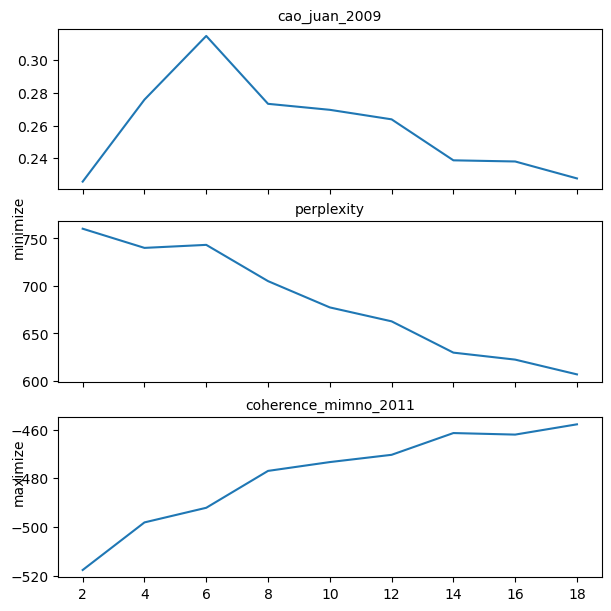

In [21]:
plot_eval_results(eval_results_by_topics);

In [ ]:
best_tm = [m for k, m in eval_results_by_topics if k == 8][0]['model']
best_tm.n_components, best_tm.doc_topic_prior, best_tm.topic_word_prior  # just to make sure

In [23]:
# Show top n keywords for each topic
def show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=15)# Topic - Keywords Dataframe

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels)

['demand.model.various.wind.buildings', 'building.monitoring.buildings.using.production', 'detection.network.wind.features.driving', 'sensor.framework.intelligent.cyber.methods', 'devices.new.machine.internet.technologies', 'intelligence.research.artificial.enterprises.applications', 'scheduling.deep.computing.architecture.cloud', 'green.smart_cities.values.applications.human']


### Document distribution over Time

In [ ]:
cmap = cm.get_cmap('tab20')
data["date"] = data.date.apply(lambda x: x.strip()[0:3] + "0")

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(best_tm.transform(dtm), columns=topic_labels), data["date"]], axis=1)
aggregated_data = combined_array.groupby('datee').mean().reset_index()
aggregated_data.set_index('date', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

plt.show()

In [24]:
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(best_tm, dtm, wordvect)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.066247 -0.034112       1        1  15.381386
1      0.029928  0.021464       2        1  14.426669
4     -0.006754  0.109340       3        1  13.729019
7      0.130329 -0.076254       4        1  13.718069
6      0.141150 -0.076633       5        1  11.651948
2     -0.120426 -0.177700       6        1  10.514400
3      0.072854  0.155655       7        1  10.401172
5     -0.180834  0.078241       8        1  10.177337, topic_info=            Term       Freq      Total Category  logprob  loglift
21        sensor  30.000000  30.000000  Default  30.0000  30.0000
5         demand  39.000000  39.000000  Default  29.0000  29.0000
14       devices  35.000000  35.000000  Default  28.0000  28.0000
15      building  35.000000  35.000000  Default  27.0000  27.0000
16  smart_cities  33.000000  33.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
2     production   7.383957  46.735070   Topic8  -4.6157   0.4398
7            new   6.472080  38.478119   Topic8  -4.7475   0.5024
96        issues   4.649031  15.446216   Topic8  -5.0783   1.0843
6        machine   5.206799  38.275125   Topic8  -4.9650   0.2902
36          used   4.649005  27.339763   Topic8  -5.0783   0.5133

[452 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
117       2  0.138501    accuracy
117       5  0.692506    accuracy
117       6  0.138501    accuracy
193       3  0.606617      active
193       7  0.404412      active
...     ...       ...         ...
13        6  0.328665        wind
13        8  0.109555        wind
127       1  0.442891  wind_power
127       6  0.442891  wind_power
127       8  0.073815  wind_power

[978 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 8, 7, 3, 4, 6])

## Results and Visualization

In [25]:
doc_lengths_bg = doc_lengths(dtm)
marg_topic = marginal_topic_distrib(best_tm.transform(dtm), doc_lengths_bg)

### Saliency

In [28]:
word_distinct = word_distinctiveness(best_tm.components_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([0.7111715 , 0.55303286, 0.25184752, 0.48160936, 0.41834523,
       1.17400164, 0.63219205, 0.93933792, 0.70127955, 0.90442342])

In [29]:
most_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=30)

array(['driving', 'offloading', 'intelligence', 'greenhouse', 'context',
       'consumer', 'values', 'harvesting', 'hardware', 'indicator',
       'maximum', 'target', 'classifiers', 'feature', 'lighting',
       'required', 'blackouts', 'fault', 'imaging', 'image', 'search',
       'cyber', 'boosting', 'commercial', 'decentralized', 'nodes',
       'enterprises', 'artificial', 'controllers', 'impacts'],
      dtype=object)

In [30]:
least_distinct_words(wordvect.get_feature_names_out(), best_tm.components_,
                    best_tm.transform(dtm), doc_lengths_bg,
                    n=30)

array(['everything', 'done', 'part', 'many', 'give', 'towards', 'whereas',
       'next', 'whole', 'full', 'third', 'integration', 'wireless',
       'production', 'data_data', 'parameters', 'analysis', 'generation',
       'methods', 'based', 'operation', 'industry', 'technologies',
       'communication', 'contribution', 'modeling', 'sources', 'approach',
       'potential', 'techniques'], dtype=object)

### Reliability Analysis

In this subsection, we assess the reliability of our topic models. Reliability is analyzed by examining the overlap between different topic models to calculate a measure of their consistency and stability.

In [31]:
#Compare Model Reliability

final = []

def set_n_to_zero(x, n):
    indexes = np.argpartition(x,-n)[-n:]
    mask = np.ones(x.size, dtype=bool)
    mask[indexes] = False
    x[mask] = 0
    return x

for i in tqdm(range(10)):
    lda_model = pickle.load(open(f'output/lda_model_{i}.pkl', "rb"))
    lda_output = pickle.load(open(f'output/lda_output_{i}.pkl', "rb"))
    final.append(np.apply_along_axis(set_n_to_zero, 1, lda_model.components_, n=20))
        

#make comparison
final = np.asarray(final)
final.shape

100%|██████████| 10/10 [00:00<00:00, 136.30it/s]


(10, 8, 822)

In [32]:
lda_model.components_

array([[ 0.        , 16.26810788, 16.12472787, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 10.5837735 ,  9.12516821, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 12.40819734,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 6.36410402,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [33]:
final[1,:,:].shape[0]

8

In [34]:
compare = np.zeros((final[1,:,:].shape[0], final[1,:,:].shape[0]))

all_models_reli = []
min_sim = 0.37
vocab = wordvect.get_feature_names_out()

for k in range(10):
    for l in range(10):
        if(k!=l):
            for i in range(final[k,:,:].shape[0]):
                for j in range(final[l,:,:].shape[0]):
                    compare[i,j] = (1 - distance.cosine(final[k,i,:],final[l,j,:]))

            stopped = False
            total_overlap = 0


            while(stopped != True):
                index = np.unravel_index(compare.argmax(), compare.shape)
                #print(index)
                total_overlap += 1
                if(compare[index] < min_sim):
                    stopped = True
                    print(vocab[np.argsort(-np.array(final[k,index[0],:]))[1:20]])
                    print(vocab[np.argsort(-np.array(final[l,index[1],:]))[1:20]])
                    print("#####\n")
                compare[index[0],:] = 0
                compare[index[1],:] = 0

            all_models_reli.append(total_overlap/final[1,:,:].shape[0])

np.asarray(all_models_reli).mean()

['building' 'devices' 'scheduling' 'demand' 'techniques' 'processing'
 'software' 'green' 'driving' 'dsm' 'global' 'improve' 'computation'
 'architecture' 'end' 'computing' 'industrial' 'networks' 'platforms']
['performance' 'buildings' 'different' 'new' 'production' 'studies'
 'sources' 'study' 'computing' 'strategy' 'intelligent' 'integrated'
 'scheduling' 'sensor' 'platform' 'materials' 'output' 'flow' 'community']
#####

['materials' 'forecasting' 'using' 'manufacturing' 'solar_power'
 'monitoring' 'resource' 'networks' 'research' 'process' 'used' 'deep'
 'environmental' 'world' 'new' 'machine' 'neural_network' 'future' 'cloud']
['approach' 'manufacturing' 'research' 'deep' 'forecasting' 'potential'
 'wind' 'new' 'waste' 'sources' 'analysis' 'generation' 'hybrid' 'plant'
 'global' 'time' 'features' 'applications' 'mobile']
#####

['building' 'devices' 'scheduling' 'demand' 'techniques' 'processing'
 'software' 'green' 'driving' 'dsm' 'global' 'improve' 'computation'
 'architecture'

0.4305555555555556

In [ ]:
np.asarray(all_models_reli)

### Word Intrusion Analysis

Word intrusion is a method to evaluate the quality of topics generated by a topic model. In this analysis, we introduce an "intruder" word into a list of words that belong to a specific topic. If the model is good, the intruder word should be easily identifiable as not belonging to the topic.

In [ ]:
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
topic = "random"
setsize = 5
chance_correction = False

for iter in range(runs):
    print(f'Word intrusion {iter} of runs\n')
    # select a topic
    if (topic == "random"):
      k = random.randint(0, K)
    else:
      k <- topic

    # select setsize - 1 most probable words
    top_words = np.argsort(best_tm.components_[k-1,:])[::-1]
    top_words_setsize = wordvect.get_feature_names_out()[top_words[:setsize]]
    
    
    
    # select intruder word with low probability from current topic, but high probability in some other topic
    V = best_tm.components_.shape[1]
    top30 = min(V, 30)
    
    high_prob_terms = []
    
    for i in range(K):
        if(i != k):
            top_words_i = np.argsort(best_tm.components_[i,:])[::-1]
            top_words_setsize_i = wordvect.get_feature_names_out()[top_words_i[:top30]]
            high_prob_terms.append(top_words_setsize_i)
    
    high_prob_terms = set(np.unique(np.asarray(high_prob_terms).flatten()))
    low_prob_terms = set(wordvect.get_feature_names_out()[top_words[math.ceil(0.25 * V):V]])
    selection_terms = high_prob_terms & low_prob_terms

    intruder = random.choices(list(selection_terms), k=1)
    
    eval_list = np.insert(
        top_words_setsize,
        random.randint(0, len(top_words_setsize)), 
        intruder)
    intruder_true_position = np.where(eval_list == intruder)[0]

    for j in range(setsize): 
        print(f"[{j}]{eval_list[j]}\n")
    
    intruder_user_selection = int(input("Enter your input: "))
    #clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
        
    
        
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")
    #print(top_words_setsize)
    #print(intruder)

In [39]:
# mean
np.mean(np.array([0.4,0.6,0.2,0.5,0.3]))

0.4

### Topic Keywords

Below, we list the top keywords for each topic generated by our LDA model. These keywords give us a glimpse into the thematic structure of the topics.

In [40]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=wordvect, lda_model=best_tm, n_words=15)# Topic - Keywords Dataframe

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels)

['demand.model.various.wind.buildings', 'building.monitoring.buildings.using.production', 'detection.network.wind.features.driving', 'sensor.framework.intelligent.cyber.methods', 'devices.new.machine.internet.technologies', 'intelligence.research.artificial.enterprises.applications', 'scheduling.deep.computing.architecture.cloud', 'green.smart_cities.values.applications.human']


### Topic Intrusion Analysis

Topic intrusion is a method to evaluate the quality of topics within documents generated by a topic model. For this analysis, an "intruder" topic is introduced into a list of topics relevant to a specific document. A good topic model should make it clear that the intruder topic does not belong to the document.

In [ ]:
# Topic instrusion
theta = best_tm.transform(dtm)
correct_selections = 0
K = best_tm.components_.shape[0]
runs = 10
n_docs = theta.shape[0]
chance_correction = False
docs = random.sample(range(n_docs), runs)
setsize = 3

for iter in range(runs):
    d = docs[iter]

    print(f"Topic intrusion {iter} of {runs}\n")
    
    doc_text = data.abstract[d]
    
    # select setsize - 1 most probable topic
    top_topics = np.argsort(theta[d,:])[::-1]
    top_topic_names = [label for idx, label in enumerate(topic_labels) if idx in top_topics[:(setsize-1)]]
    intruder_topic = random.choices(list(top_topics[math.ceil((K+1)/2):K-1]), k=1)
    intruder_topic_name = topic_labels[intruder_topic[0]]
    
    eval_list = np.insert(
        top_topic_names,
        random.randint(0, len(top_topic_names)), 
        intruder_topic_name)
    
    intruder_true_position = np.where(eval_list == intruder_topic_name)[0]
    
    print(f'{doc_text}\n')
    
    for i in range(setsize): 
        print(f"[{i}] {eval_list[i]}\n")

    intruder_user_selection = int(input("Enter your input: "))
    clear_output(wait=True)
    
    if (intruder_true_position == intruder_user_selection):
        print("CORRECT SELECTION\n")
        correct_selections +=  1
    else:
        print("FALSE SELECTION\n")
    
performance = correct_selections / runs

if(chance_correction):
    random_probabilty = 1 / setsize
    performance = (performance - random_probabilty) / (1 - random_probabilty)
  
print(f"Performance: {performance} ({correct_selections} out of {runs} runs)\n")
